# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

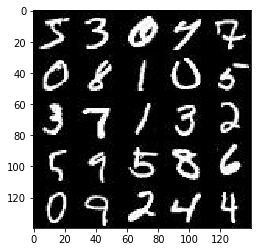

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

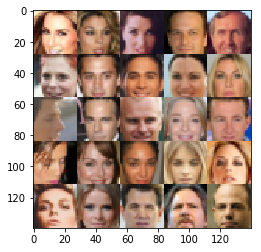

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_image')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_image, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        alpha = 0.2
        keep_prob = 0.9
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        keep_prob = 0.9
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                          labels=tf.ones_like(d_model_real)) )
    
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)) )
    
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.ones_like(d_model_fake)) )
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learningrate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images *= 2
                steps += 1                
                # sample noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                
                    print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, './chackpoints/generator.ckpt')
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Generator Loss: 8.4307 Discriminator Loss: 0.0003...
Epoch 1/2 Generator Loss: 17.4395 Discriminator Loss: 0.0493...
Epoch 1/2 Generator Loss: 4.8421 Discriminator Loss: 0.2941...
Epoch 1/2 Generator Loss: 5.8915 Discriminator Loss: 0.0376...
Epoch 1/2 Generator Loss: 1.6927 Discriminator Loss: 0.5102...
Epoch 1/2 Generator Loss: 10.6777 Discriminator Loss: 2.4559...
Epoch 1/2 Generator Loss: 1.0252 Discriminator Loss: 0.9153...
Epoch 1/2 Generator Loss: 2.0517 Discriminator Loss: 0.7803...
Epoch 1/2 Generator Loss: 1.2741 Discriminator Loss: 0.6793...
Epoch 1/2 Generator Loss: 1.6760 Discriminator Loss: 0.8796...


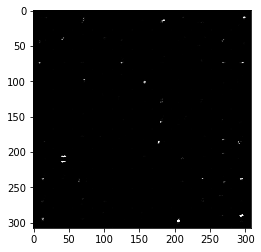

Epoch 1/2 Generator Loss: 1.4755 Discriminator Loss: 1.1052...
Epoch 1/2 Generator Loss: 1.8289 Discriminator Loss: 0.8314...
Epoch 1/2 Generator Loss: 2.2428 Discriminator Loss: 0.9210...
Epoch 1/2 Generator Loss: 1.2253 Discriminator Loss: 1.2549...
Epoch 1/2 Generator Loss: 0.8451 Discriminator Loss: 0.9381...
Epoch 1/2 Generator Loss: 2.3374 Discriminator Loss: 1.0893...
Epoch 1/2 Generator Loss: 1.0869 Discriminator Loss: 0.9393...
Epoch 1/2 Generator Loss: 0.2972 Discriminator Loss: 1.6643...
Epoch 1/2 Generator Loss: 1.1161 Discriminator Loss: 0.8395...
Epoch 1/2 Generator Loss: 1.2917 Discriminator Loss: 0.6600...


Epoch 1/2 Generator Loss: 1.2338 Discriminator Loss: 0.6912...
Epoch 1/2 Generator Loss: 0.3888 Discriminator Loss: 1.5291...
Epoch 1/2 Generator Loss: 1.1770 Discriminator Loss: 0.8113...
Epoch 1/2 Generator Loss: 1.2906 Discriminator Loss: 0.7260...
Epoch 1/2 Generator Loss: 0.7662 Discriminator Loss: 0.9808...
Epoch 1/2 Generator Loss: 0.7207 Discriminator Loss: 1.0550...
Epoch 1/2 Generator Loss: 1.4407 Discriminator Loss: 0.6412...
Epoch 1/2 Generator Loss: 1.1549 Discriminator Loss: 1.0733...
Epoch 1/2 Generator Loss: 0.7574 Discriminator Loss: 1.1108...
Epoch 1/2 Generator Loss: 0.4795 Discriminator Loss: 1.3086...


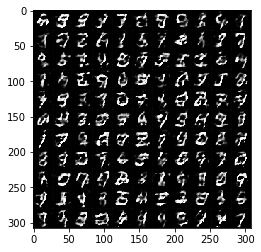

Epoch 1/2 Generator Loss: 0.6463 Discriminator Loss: 1.1071...
Epoch 1/2 Generator Loss: 3.3351 Discriminator Loss: 2.0662...
Epoch 1/2 Generator Loss: 1.2969 Discriminator Loss: 1.0712...
Epoch 1/2 Generator Loss: 0.6818 Discriminator Loss: 1.2828...
Epoch 1/2 Generator Loss: 1.6466 Discriminator Loss: 1.2051...
Epoch 1/2 Generator Loss: 0.4533 Discriminator Loss: 1.3657...
Epoch 1/2 Generator Loss: 1.6328 Discriminator Loss: 0.9701...
Epoch 1/2 Generator Loss: 1.0148 Discriminator Loss: 0.9660...
Epoch 1/2 Generator Loss: 0.8482 Discriminator Loss: 1.1108...
Epoch 1/2 Generator Loss: 1.4039 Discriminator Loss: 1.0684...


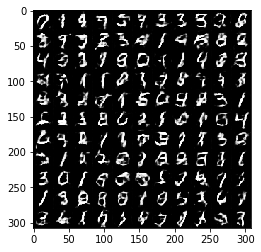

Epoch 1/2 Generator Loss: 1.7649 Discriminator Loss: 1.1720...
Epoch 1/2 Generator Loss: 1.2271 Discriminator Loss: 0.7961...
Epoch 1/2 Generator Loss: 1.6647 Discriminator Loss: 1.1815...
Epoch 1/2 Generator Loss: 1.0174 Discriminator Loss: 1.0869...
Epoch 1/2 Generator Loss: 1.6366 Discriminator Loss: 1.2545...
Epoch 1/2 Generator Loss: 1.1369 Discriminator Loss: 1.0109...
Epoch 2/2 Generator Loss: 0.4985 Discriminator Loss: 1.3565...
Epoch 2/2 Generator Loss: 0.8243 Discriminator Loss: 1.0133...
Epoch 2/2 Generator Loss: 2.1711 Discriminator Loss: 1.4095...
Epoch 2/2 Generator Loss: 0.9335 Discriminator Loss: 1.0486...


Epoch 2/2 Generator Loss: 1.3347 Discriminator Loss: 0.8897...
Epoch 2/2 Generator Loss: 0.6526 Discriminator Loss: 1.2063...
Epoch 2/2 Generator Loss: 1.0406 Discriminator Loss: 1.0282...
Epoch 2/2 Generator Loss: 0.5795 Discriminator Loss: 1.1928...
Epoch 2/2 Generator Loss: 1.2988 Discriminator Loss: 1.0218...
Epoch 2/2 Generator Loss: 1.2268 Discriminator Loss: 0.8476...
Epoch 2/2 Generator Loss: 0.8177 Discriminator Loss: 1.0508...
Epoch 2/2 Generator Loss: 1.3556 Discriminator Loss: 1.0109...
Epoch 2/2 Generator Loss: 0.6249 Discriminator Loss: 1.1352...
Epoch 2/2 Generator Loss: 0.3153 Discriminator Loss: 1.6961...


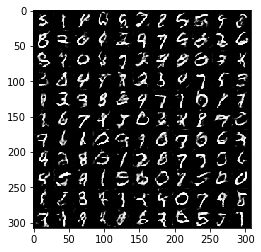

Epoch 2/2 Generator Loss: 1.1204 Discriminator Loss: 0.9642...
Epoch 2/2 Generator Loss: 0.5133 Discriminator Loss: 1.3337...
Epoch 2/2 Generator Loss: 0.9919 Discriminator Loss: 0.9354...
Epoch 2/2 Generator Loss: 0.1094 Discriminator Loss: 3.6656...
Epoch 2/2 Generator Loss: 0.6633 Discriminator Loss: 1.3779...
Epoch 2/2 Generator Loss: 0.4726 Discriminator Loss: 1.3240...
Epoch 2/2 Generator Loss: 1.0987 Discriminator Loss: 0.9238...
Epoch 2/2 Generator Loss: 1.2923 Discriminator Loss: 0.9733...
Epoch 2/2 Generator Loss: 1.4326 Discriminator Loss: 0.8908...
Epoch 2/2 Generator Loss: 0.6925 Discriminator Loss: 1.0601...


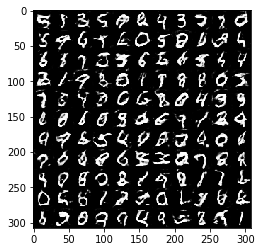

Epoch 2/2 Generator Loss: 0.8743 Discriminator Loss: 1.2407...
Epoch 2/2 Generator Loss: 0.8539 Discriminator Loss: 0.9873...
Epoch 2/2 Generator Loss: 1.0056 Discriminator Loss: 1.0828...
Epoch 2/2 Generator Loss: 0.6370 Discriminator Loss: 1.1916...
Epoch 2/2 Generator Loss: 0.9447 Discriminator Loss: 1.1179...
Epoch 2/2 Generator Loss: 0.9245 Discriminator Loss: 0.9071...
Epoch 2/2 Generator Loss: 0.8380 Discriminator Loss: 1.0158...
Epoch 2/2 Generator Loss: 0.4965 Discriminator Loss: 1.3813...
Epoch 2/2 Generator Loss: 0.7826 Discriminator Loss: 1.0274...
Epoch 2/2 Generator Loss: 0.7315 Discriminator Loss: 1.0159...


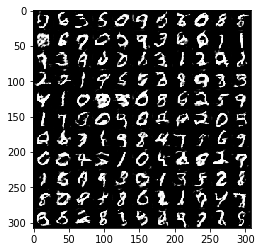

Epoch 2/2 Generator Loss: 0.5164 Discriminator Loss: 1.3451...
Epoch 2/2 Generator Loss: 1.0224 Discriminator Loss: 1.0844...
Epoch 2/2 Generator Loss: 0.9195 Discriminator Loss: 0.9011...
Epoch 2/2 Generator Loss: 1.3248 Discriminator Loss: 1.1188...
Epoch 2/2 Generator Loss: 1.0763 Discriminator Loss: 1.0426...
Epoch 2/2 Generator Loss: 0.7528 Discriminator Loss: 1.1004...
Epoch 2/2 Generator Loss: 1.0854 Discriminator Loss: 0.9917...
Epoch 2/2 Generator Loss: 1.7174 Discriminator Loss: 0.9463...
Epoch 2/2 Generator Loss: 1.7938 Discriminator Loss: 1.2033...
Epoch 2/2 Generator Loss: 1.4508 Discriminator Loss: 1.0348...


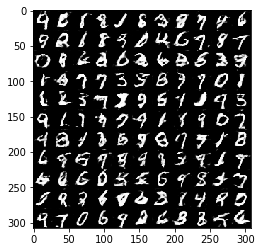

Epoch 2/2 Generator Loss: 0.2765 Discriminator Loss: 1.8630...
Epoch 2/2 Generator Loss: 0.9151 Discriminator Loss: 1.0883...
Epoch 2/2 Generator Loss: 1.0113 Discriminator Loss: 0.9025...


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Generator Loss: 30.0398 Discriminator Loss: 0.0116...
Epoch 1/1 Generator Loss: 10.5308 Discriminator Loss: 0.0013...
Epoch 1/1 Generator Loss: 16.5299 Discriminator Loss: 0.0763...
Epoch 1/1 Generator Loss: 2.3606 Discriminator Loss: 0.7440...
Epoch 1/1 Generator Loss: 17.0511 Discriminator Loss: 2.6635...
Epoch 1/1 Generator Loss: 1.1120 Discriminator Loss: 0.7593...
Epoch 1/1 Generator Loss: 4.7196 Discriminator Loss: 0.1724...
Epoch 1/1 Generator Loss: 3.7629 Discriminator Loss: 0.1342...
Epoch 1/1 Generator Loss: 1.7704 Discriminator Loss: 0.6625...
Epoch 1/1 Generator Loss: 2.7453 Discriminator Loss: 0.4190...


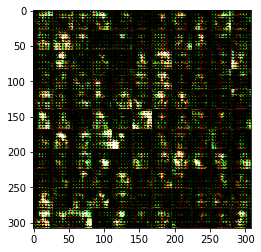

Epoch 1/1 Generator Loss: 2.1837 Discriminator Loss: 0.3277...
Epoch 1/1 Generator Loss: 2.8667 Discriminator Loss: 0.2383...
Epoch 1/1 Generator Loss: 1.3073 Discriminator Loss: 0.5551...
Epoch 1/1 Generator Loss: 1.5312 Discriminator Loss: 0.4514...
Epoch 1/1 Generator Loss: 2.5278 Discriminator Loss: 0.1842...
Epoch 1/1 Generator Loss: 7.2831 Discriminator Loss: 0.4120...
Epoch 1/1 Generator Loss: 2.2667 Discriminator Loss: 0.9038...
Epoch 1/1 Generator Loss: 3.1086 Discriminator Loss: 0.4760...
Epoch 1/1 Generator Loss: 1.5430 Discriminator Loss: 0.6774...
Epoch 1/1 Generator Loss: 0.6025 Discriminator Loss: 1.4323...


Epoch 1/1 Generator Loss: 1.4607 Discriminator Loss: 1.4088...
Epoch 1/1 Generator Loss: 1.4539 Discriminator Loss: 0.8216...
Epoch 1/1 Generator Loss: 1.0109 Discriminator Loss: 1.1964...
Epoch 1/1 Generator Loss: 1.4697 Discriminator Loss: 2.0411...
Epoch 1/1 Generator Loss: 0.3007 Discriminator Loss: 1.7240...
Epoch 1/1 Generator Loss: 0.7462 Discriminator Loss: 0.9551...
Epoch 1/1 Generator Loss: 0.8705 Discriminator Loss: 0.9152...
Epoch 1/1 Generator Loss: 2.1415 Discriminator Loss: 1.4893...
Epoch 1/1 Generator Loss: 1.0226 Discriminator Loss: 0.7454...
Epoch 1/1 Generator Loss: 1.3575 Discriminator Loss: 1.0170...


Epoch 1/1 Generator Loss: 1.2526 Discriminator Loss: 0.9879...
Epoch 1/1 Generator Loss: 0.9178 Discriminator Loss: 1.0991...
Epoch 1/1 Generator Loss: 1.6623 Discriminator Loss: 0.9543...
Epoch 1/1 Generator Loss: 3.3690 Discriminator Loss: 2.7238...
Epoch 1/1 Generator Loss: 0.2162 Discriminator Loss: 1.8581...
Epoch 1/1 Generator Loss: 0.7626 Discriminator Loss: 1.1572...
Epoch 1/1 Generator Loss: 0.9407 Discriminator Loss: 0.9920...
Epoch 1/1 Generator Loss: 0.7645 Discriminator Loss: 1.0745...
Epoch 1/1 Generator Loss: 1.1198 Discriminator Loss: 0.9973...
Epoch 1/1 Generator Loss: 0.6576 Discriminator Loss: 1.1272...


Epoch 1/1 Generator Loss: 0.1746 Discriminator Loss: 2.1657...
Epoch 1/1 Generator Loss: 0.8271 Discriminator Loss: 1.0255...
Epoch 1/1 Generator Loss: 0.7831 Discriminator Loss: 1.1289...
Epoch 1/1 Generator Loss: 0.8670 Discriminator Loss: 1.0673...
Epoch 1/1 Generator Loss: 1.8073 Discriminator Loss: 1.2277...
Epoch 1/1 Generator Loss: 0.8234 Discriminator Loss: 1.1211...
Epoch 1/1 Generator Loss: 1.6080 Discriminator Loss: 0.8518...
Epoch 1/1 Generator Loss: 0.7144 Discriminator Loss: 1.2072...
Epoch 1/1 Generator Loss: 1.4969 Discriminator Loss: 0.9852...
Epoch 1/1 Generator Loss: 0.7984 Discriminator Loss: 1.2548...


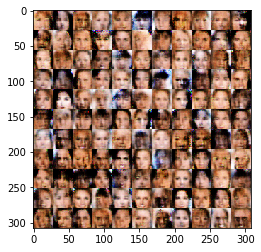

Epoch 1/1 Generator Loss: 0.3584 Discriminator Loss: 1.5817...
Epoch 1/1 Generator Loss: 0.4554 Discriminator Loss: 1.3159...
Epoch 1/1 Generator Loss: 1.0671 Discriminator Loss: 0.9784...
Epoch 1/1 Generator Loss: 0.8708 Discriminator Loss: 1.0494...
Epoch 1/1 Generator Loss: 0.8253 Discriminator Loss: 1.0223...
Epoch 1/1 Generator Loss: 1.7398 Discriminator Loss: 1.3018...
Epoch 1/1 Generator Loss: 0.8677 Discriminator Loss: 0.9123...
Epoch 1/1 Generator Loss: 0.7232 Discriminator Loss: 1.4585...
Epoch 1/1 Generator Loss: 0.2155 Discriminator Loss: 1.9544...
Epoch 1/1 Generator Loss: 0.8127 Discriminator Loss: 1.2655...


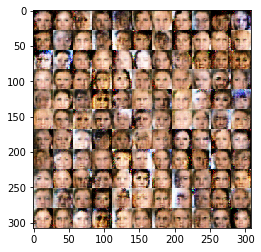

Epoch 1/1 Generator Loss: 1.2841 Discriminator Loss: 1.1341...
Epoch 1/1 Generator Loss: 1.0573 Discriminator Loss: 1.0582...
Epoch 1/1 Generator Loss: 0.5583 Discriminator Loss: 1.3155...
Epoch 1/1 Generator Loss: 1.3329 Discriminator Loss: 1.3354...
Epoch 1/1 Generator Loss: 1.0736 Discriminator Loss: 1.4303...
Epoch 1/1 Generator Loss: 2.1313 Discriminator Loss: 1.8719...
Epoch 1/1 Generator Loss: 1.0651 Discriminator Loss: 1.0621...
Epoch 1/1 Generator Loss: 2.3634 Discriminator Loss: 1.8220...
Epoch 1/1 Generator Loss: 0.9596 Discriminator Loss: 1.0479...
Epoch 1/1 Generator Loss: 0.6893 Discriminator Loss: 1.2681...


Epoch 1/1 Generator Loss: 1.1756 Discriminator Loss: 1.4204...
Epoch 1/1 Generator Loss: 0.4112 Discriminator Loss: 1.4164...
Epoch 1/1 Generator Loss: 1.5542 Discriminator Loss: 1.4485...
Epoch 1/1 Generator Loss: 1.2158 Discriminator Loss: 1.0543...
Epoch 1/1 Generator Loss: 0.7943 Discriminator Loss: 1.1620...
Epoch 1/1 Generator Loss: 3.3147 Discriminator Loss: 3.3459...
Epoch 1/1 Generator Loss: 0.7900 Discriminator Loss: 1.3457...
Epoch 1/1 Generator Loss: 0.9392 Discriminator Loss: 1.2920...
Epoch 1/1 Generator Loss: 0.8844 Discriminator Loss: 1.1671...
Epoch 1/1 Generator Loss: 0.8972 Discriminator Loss: 1.3316...


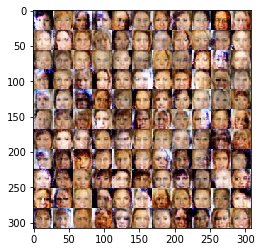

Epoch 1/1 Generator Loss: 0.2261 Discriminator Loss: 1.8798...
Epoch 1/1 Generator Loss: 0.6178 Discriminator Loss: 1.3740...
Epoch 1/1 Generator Loss: 0.2906 Discriminator Loss: 1.6557...
Epoch 1/1 Generator Loss: 1.0338 Discriminator Loss: 1.2633...
Epoch 1/1 Generator Loss: 0.7983 Discriminator Loss: 1.1823...
Epoch 1/1 Generator Loss: 0.7648 Discriminator Loss: 1.3538...
Epoch 1/1 Generator Loss: 0.4223 Discriminator Loss: 1.4146...
Epoch 1/1 Generator Loss: 0.7115 Discriminator Loss: 1.3054...
Epoch 1/1 Generator Loss: 0.5434 Discriminator Loss: 1.2616...
Epoch 1/1 Generator Loss: 1.3951 Discriminator Loss: 1.4236...


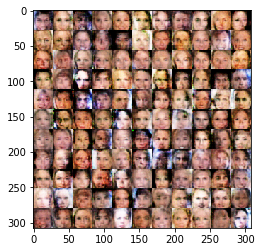

Epoch 1/1 Generator Loss: 0.6408 Discriminator Loss: 1.3725...
Epoch 1/1 Generator Loss: 0.6871 Discriminator Loss: 1.2240...
Epoch 1/1 Generator Loss: 0.4884 Discriminator Loss: 1.3415...
Epoch 1/1 Generator Loss: 3.2399 Discriminator Loss: 2.7646...
Epoch 1/1 Generator Loss: 0.7305 Discriminator Loss: 1.3444...
Epoch 1/1 Generator Loss: 0.8068 Discriminator Loss: 1.2466...
Epoch 1/1 Generator Loss: 1.4082 Discriminator Loss: 1.3566...
Epoch 1/1 Generator Loss: 1.0974 Discriminator Loss: 1.1995...
Epoch 1/1 Generator Loss: 0.4093 Discriminator Loss: 1.4612...
Epoch 1/1 Generator Loss: 0.2194 Discriminator Loss: 1.8854...


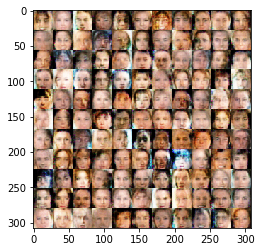

Epoch 1/1 Generator Loss: 0.4268 Discriminator Loss: 1.5226...
Epoch 1/1 Generator Loss: 0.3980 Discriminator Loss: 1.3608...
Epoch 1/1 Generator Loss: 0.8979 Discriminator Loss: 1.2051...
Epoch 1/1 Generator Loss: 0.4354 Discriminator Loss: 1.3545...
Epoch 1/1 Generator Loss: 0.9506 Discriminator Loss: 1.2164...
Epoch 1/1 Generator Loss: 1.0086 Discriminator Loss: 1.3988...
Epoch 1/1 Generator Loss: 0.4259 Discriminator Loss: 1.4009...
Epoch 1/1 Generator Loss: 0.8088 Discriminator Loss: 1.1216...
Epoch 1/1 Generator Loss: 0.3125 Discriminator Loss: 1.5280...
Epoch 1/1 Generator Loss: 0.6476 Discriminator Loss: 1.3786...


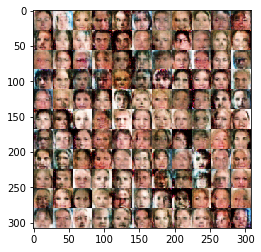

Epoch 1/1 Generator Loss: 1.1307 Discriminator Loss: 1.3413...
Epoch 1/1 Generator Loss: 1.3153 Discriminator Loss: 1.5231...
Epoch 1/1 Generator Loss: 1.2799 Discriminator Loss: 1.4723...
Epoch 1/1 Generator Loss: 0.6948 Discriminator Loss: 1.1962...
Epoch 1/1 Generator Loss: 0.5280 Discriminator Loss: 1.4466...
Epoch 1/1 Generator Loss: 0.9058 Discriminator Loss: 1.2352...
Epoch 1/1 Generator Loss: 0.8167 Discriminator Loss: 1.2168...
Epoch 1/1 Generator Loss: 1.0308 Discriminator Loss: 1.2537...
Epoch 1/1 Generator Loss: 1.0394 Discriminator Loss: 1.4249...
Epoch 1/1 Generator Loss: 0.8119 Discriminator Loss: 1.2366...


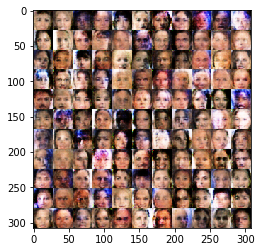

Epoch 1/1 Generator Loss: 0.7111 Discriminator Loss: 1.5327...
Epoch 1/1 Generator Loss: 0.9263 Discriminator Loss: 1.2444...
Epoch 1/1 Generator Loss: 0.7128 Discriminator Loss: 1.4426...
Epoch 1/1 Generator Loss: 0.2909 Discriminator Loss: 1.7246...
Epoch 1/1 Generator Loss: 0.6787 Discriminator Loss: 1.3128...
Epoch 1/1 Generator Loss: 0.4431 Discriminator Loss: 1.4532...
Epoch 1/1 Generator Loss: 0.6223 Discriminator Loss: 1.2477...
Epoch 1/1 Generator Loss: 0.7553 Discriminator Loss: 1.4581...
Epoch 1/1 Generator Loss: 0.8095 Discriminator Loss: 1.1881...
Epoch 1/1 Generator Loss: 0.3747 Discriminator Loss: 1.5560...


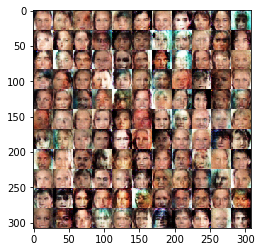

Epoch 1/1 Generator Loss: 0.6802 Discriminator Loss: 1.2565...
Epoch 1/1 Generator Loss: 0.5082 Discriminator Loss: 1.5202...
Epoch 1/1 Generator Loss: 0.4685 Discriminator Loss: 1.4823...
Epoch 1/1 Generator Loss: 0.6372 Discriminator Loss: 1.3369...
Epoch 1/1 Generator Loss: 0.4811 Discriminator Loss: 1.3962...
Epoch 1/1 Generator Loss: 0.7496 Discriminator Loss: 1.3295...
Epoch 1/1 Generator Loss: 0.7579 Discriminator Loss: 1.3885...
Epoch 1/1 Generator Loss: 0.5268 Discriminator Loss: 1.3364...
Epoch 1/1 Generator Loss: 0.5791 Discriminator Loss: 1.2581...
Epoch 1/1 Generator Loss: 0.6620 Discriminator Loss: 1.3888...


Epoch 1/1 Generator Loss: 0.7265 Discriminator Loss: 1.4486...
Epoch 1/1 Generator Loss: 0.6769 Discriminator Loss: 1.4188...
Epoch 1/1 Generator Loss: 1.0670 Discriminator Loss: 1.4342...
Epoch 1/1 Generator Loss: 0.6283 Discriminator Loss: 1.4096...
Epoch 1/1 Generator Loss: 0.9463 Discriminator Loss: 1.4876...
Epoch 1/1 Generator Loss: 0.7557 Discriminator Loss: 1.4293...
Epoch 1/1 Generator Loss: 0.4479 Discriminator Loss: 1.6960...
Epoch 1/1 Generator Loss: 0.9588 Discriminator Loss: 1.3200...
Epoch 1/1 Generator Loss: 0.5091 Discriminator Loss: 1.3585...
Epoch 1/1 Generator Loss: 1.0996 Discriminator Loss: 1.4058...


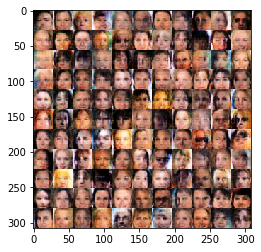

Epoch 1/1 Generator Loss: 0.4902 Discriminator Loss: 1.5153...
Epoch 1/1 Generator Loss: 0.6603 Discriminator Loss: 1.3813...
Epoch 1/1 Generator Loss: 0.4046 Discriminator Loss: 1.5140...
Epoch 1/1 Generator Loss: 0.9163 Discriminator Loss: 1.3264...
Epoch 1/1 Generator Loss: 0.7737 Discriminator Loss: 1.4155...
Epoch 1/1 Generator Loss: 0.8837 Discriminator Loss: 1.4387...
Epoch 1/1 Generator Loss: 0.6099 Discriminator Loss: 1.2915...
Epoch 1/1 Generator Loss: 0.6499 Discriminator Loss: 1.2759...


In [16]:
batch_size = 128
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.